In [3]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import contextily as ctx 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Traveling Salesperson Problem
The canonical [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) is stated as:
>  "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

This is generalizable to finding the shortest [Hamiltonian cycle](http://mathworld.wolfram.com/HamiltonianCycle.html) on a fully connected graph (i.e. all nodes can be reached from all other nodes).

This problem is [NP-hard](https://en.wikipedia.org/wiki/P_versus_NP_problem), meaning it is not possible for an algorithm to solve all instances of the problem quickly (i.e. in polynomial time). However, there are many approximate and heuristic approaches which can give reasonable solutions in shorter time.

In [5]:
place_name = 'New York City, NY, United States'
place_roads = ox.graph_from_place(place_name)


In [ ]:
# save graph to file for reuse
ox.io.save_graphml(place_roads, 'nyc_osmnx.graphml')

In [4]:
# loading graph from a file
place_roads = ox.io.load_graphml('nyc_osmnx.graphml')

In [6]:
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

<AxesSubplot:>

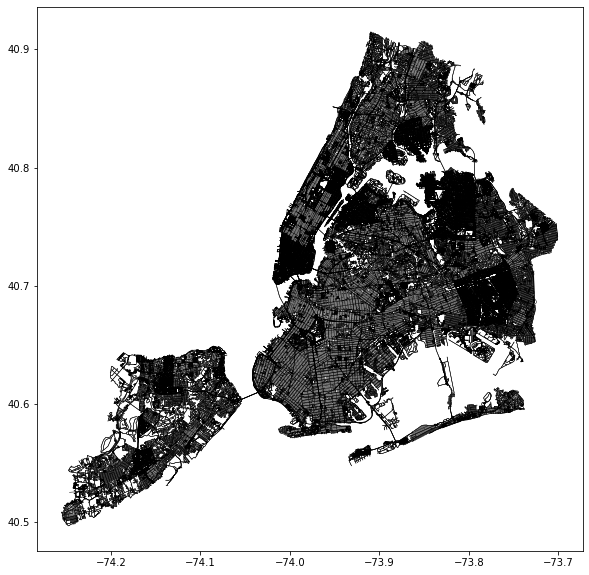

In [9]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0, 0, 0], linewidth=0.5)

Let's say you wanted to do a ice cream crawl: you want to visit every ice cream shop in a city. What is the shortest route that you would take that takes you to every ice cream shop in a city and brings you back to your starting point?

In [8]:
place_ice_cream = ox.geometries.geometries_from_place(place_name, tags={"amenity":"ice_cream"})

#some of the ice cream shops return polygons instead of points, so we need to take their centroids
place_ice_cream = place_ice_cream.to_crs("epsg:3857") #projecting to Web-Mercator for more accurate centroids
place_ice_cream["geometry"] = place_ice_cream["geometry"].centroid
place_ice_cream = place_ice_cream.to_crs("epsg:4326") #projecting back to lat/long

place_ice_cream

addr:housenumber addr:postcode       addr:street  \
element_type osmid                                                         
node         419360637                95         10003  East 10th Street   
             419364720                81         11201     Bergen Street   
             475485737                 1         11201      Water Street   
             832243111               186           NaN  Underhill Avenue   
             1270769388              NaN           NaN               NaN   
...                                  ...           ...               ...   
way          576014904               NaN           NaN               NaN   
             724196597               NaN           NaN               NaN   
             904169911               NaN           NaN               NaN   
             904206111               NaN           NaN               NaN   
             904206135               NaN           NaN               NaN   

                           amenity                        name  \
element_type osmid                                               
node         419360637   ice_cream           Sundaes and Cones   
             419364720   ice_cream                 Van Leeuwen   
             475485737   ice_cream  Brooklyn Ice Cream Factory   
             832243111   ice_cream       Blue Marble Ice Cream   
             1270769388  ice_cream      Laboratorio del Gelato   
...                            ...                         ...   
way          576014904   ice_cream                         NaN   
             724196597   ice_cream               La Newyorkina   
             904169911   ice_cream                   Red Mango   
             904206111   ice_cream          Rita's Italian Ice   
             904206135   ice_cream                      Carvel   

                                                             opening_hours  \
element_type osmid                                                           
node         419360637                                   Mo-Su 12:00-22:00   
             419364720   Mo-Th 07:00-24:00; Fr 07:00-01:00; Sa 09:00-01...   
             475485737                                                 NaN   
             832243111                                                 NaN   
             1270769388                                                NaN   
...                                                                    ...   
way          576014904                                                 NaN   
             724196597                                                 NaN   
             904169911                                                 NaN   
             904206111                                                 NaN   
             904206135                                                 NaN   

                        outdoor_seating                    geometry addr:city  \
element_type osmid                                                              
node         419360637            bench  POINT (-73.98941 40.73099)       NaN   
             419364720              NaN  POINT (-73.99015 40.68670)  Brooklyn   
             475485737              NaN  POINT (-73.99475 40.70321)  Brooklyn   
             832243111              yes  POINT (-73.96690 40.67500)  Brooklyn   
             1270769388             NaN  POINT (-73.98710 40.72222)       NaN   
...                                 ...                         ...       ...   
way          576014904              NaN  POINT (-74.04642 40.68969)       NaN   
             724196597              NaN  POINT (-73.99090 40.73015)       NaN   
             904169911               no  POINT (-74.16452 40.58154)       NaN   
             904206111              NaN  POINT (-74.16670 40.58157)       NaN   
             904206135              NaN  POINT (-74.16515 40.57757)       NaN   

                        addr:country  ... drink:beer drink:wine official_name  \
element_type osmid        

In [10]:
place_ice_cream

addr:housenumber addr:postcode       addr:street  \
element_type osmid                                                         
node         419360637                95         10003  East 10th Street   
             419364720                81         11201     Bergen Street   
             475485737                 1         11201      Water Street   
             832243111               186           NaN  Underhill Avenue   
             1270769388              NaN           NaN               NaN   
...                                  ...           ...               ...   
way          576014904               NaN           NaN               NaN   
             724196597               NaN           NaN               NaN   
             904169911               NaN           NaN               NaN   
             904206111               NaN           NaN               NaN   
             904206135               NaN           NaN               NaN   

                           amenity                        name  \
element_type osmid                                               
node         419360637   ice_cream           Sundaes and Cones   
             419364720   ice_cream                 Van Leeuwen   
             475485737   ice_cream  Brooklyn Ice Cream Factory   
             832243111   ice_cream       Blue Marble Ice Cream   
             1270769388  ice_cream      Laboratorio del Gelato   
...                            ...                         ...   
way          576014904   ice_cream                         NaN   
             724196597   ice_cream               La Newyorkina   
             904169911   ice_cream                   Red Mango   
             904206111   ice_cream          Rita's Italian Ice   
             904206135   ice_cream                      Carvel   

                                                             opening_hours  \
element_type osmid                                                           
node         419360637                                   Mo-Su 12:00-22:00   
             419364720   Mo-Th 07:00-24:00; Fr 07:00-01:00; Sa 09:00-01...   
             475485737                                                 NaN   
             832243111                                                 NaN   
             1270769388                                                NaN   
...                                                                    ...   
way          576014904                                                 NaN   
             724196597                                                 NaN   
             904169911                                                 NaN   
             904206111                                                 NaN   
             904206135                                                 NaN   

                        outdoor_seating                    geometry addr:city  \
element_type osmid                                                              
node         419360637            bench  POINT (-73.98941 40.73099)       NaN   
             419364720              NaN  POINT (-73.99015 40.68670)  Brooklyn   
             475485737              NaN  POINT (-73.99475 40.70321)  Brooklyn   
             832243111              yes  POINT (-73.96690 40.67500)  Brooklyn   
             1270769388             NaN  POINT (-73.98710 40.72222)       NaN   
...                                 ...                         ...       ...   
way          576014904              NaN  POINT (-74.04642 40.68969)       NaN   
             724196597              NaN  POINT (-73.99090 40.73015)       NaN   
             904169911               no  POINT (-74.16452 40.58154)       NaN   
             904206111              NaN  POINT (-74.16670 40.58157)       NaN   
             904206135              NaN  POINT (-74.16515 40.57757)       NaN   

                        addr:country  ... drink:beer drink:wine official_name  \
element_type osmid        

In [12]:
ice_cream_nodes = ox.distance.nearest_nodes(place_roads, place_ice_cream.geometry.x, place_ice_cream.geometry.y)
ice_cream_nodes

[8309479610,
 42492239,
 999184475,
 42474968,
 4598752863,
 8262309038,
 8314977757,
 8236746391,
 6406731704,
 42428799,
 8386198042,
 42443349,
 42442451,
 5115916405,
 1061531790,
 8916499429,
 7465125494,
 4216045841,
 42491627,
 42870183,
 42466073,
 42495230,
 6638433920,
 5899960327,
 3891969471,
 7579069159,
 6369613044,
 42469645,
 4964127740,
 42434959,
 6210777837,
 8669764313,
 6263083540,
 6597498400,
 8288329067,
 5396215013,
 42807319,
 42876552,
 5487925826,
 8250715772,
 42466011,
 6814303424,
 7492443638,
 7570756477,
 8576198811,
 8780665829,
 8309479239,
 5510458199,
 4320028830,
 42827392,
 5490750794,
 7015842113,
 2111006220,
 6406731684,
 42469492,
 4115968602,
 42506318,
 8307641532,
 7465420399,
 42453226,
 4708375542,
 5830644226,
 8087406846,
 42807108,
 42487567,
 5429824400,
 42827669,
 42885444,
 2484549752,
 42899570,
 42497261,
 5482174044,
 42495404,
 42512343,
 6369613026,
 8309469094,
 8506346379,
 6814288111,
 6816458072,
 6450635184,
 42487597,
 4

## Exercise
Plot the locations of the ice cream shops on the map of the roads

## Compute shortest path matrix

In [ ]:
shortest_path_matrix = np.zeros([len(ice_cream_nodes),len(ice_cream_nodes)])
for idx_i, orig in enumerate(ice_cream_nodes):
    shortest_paths = nx.single_source_dijkstra_path_length(place_roads, orig, weight='length')
    for idx_j, dest in enumerate(ice_cream_nodes):
        shortest_path_matrix[idx_i, idx_j] = shortest_paths[dest]
shortest_path_matrix

In [ ]:
ice_cream_graph = nx.from_numpy_matrix(shortest_path_matrix, create_using=nx.MultiDiGraph)

In [9]:
# new graph indexes from 0
ice_cream_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136))

In [10]:
# rename node labels using original labels
ice_cream_graph = nx.relabel_nodes(ice_cream_graph,{k:v for k, v in zip(ice_cream_graph.nodes, ice_cream_nodes)})
ice_cream_graph.nodes

NodeView((42430886, 42492239, 999184395, 42474968, 7465391419, 3004844986, 2698702581, 42854333, 6406731704, 42428799, 4205565536, 5115916405, 5482687360, 4376122105, 42875051, 4216045804, 42870183, 42466073, 6638433920, 3891969471, 42469645, 4964127740, 42434959, 6210777837, 42435663, 6263083540, 6597498400, 5396215013, 42807319, 42876552, 42439406, 42466011, 7654949115, 7492443638, 7570756477, 42732035, 4544455461, 3834459546, 5510458199, 4320028830, 42827392, 5490750794, 7015842113, 2111006220, 6406731684, 42469492, 4115968602, 42506318, 42438034, 42431712, 42453226, 4708375542, 42826882, 5830644226, 7229660637, 42491627, 5159433792, 42807083, 42807108, 42487567, 5429824400, 42827669, 42885444, 2484549752, 42899570, 42497261, 42815557, 42495404, 42512343, 6369613026, 3891969467, 5482326727, 6814288111, 1372888911, 6816458072, 42487583, 6450635184, 42487597, 42497631, 42433551, 42848654, 42442848, 1815133244, 3783144655, 4235734223, 7641718028, 7113914110, 7134855841, 42492250, 38329

## Exercise
Implement each of the following methods to see how good of a TSP path you can obtain.

## Method 1: Random
Let's start by setting a baseline; how well can we do by starting at a random node and choosing a random node out of the ones remaining each time? 

After you find the path, draw it on the map and print its length. (You don't need to draw the actual roads taken, just draw lines between the nodes.)

## Method 2: Greedy
Now, let's try to choose nodes more intelligently: start at a random node again, but instead of choosing a random node each time, always choose the node closest to the current node each time.

Again, draw the path on the map and print its length.

## Method 3: Random with 2-opt swapping

You may have noticed that both paths contain a lot of edges that cross each other, which is nonideal. However, there exists an algorithm to remove all the paths that cross each other from a Hamiltonian cycle: the [2-opt](https://en.wikipedia.org/wiki/2-opt) algorithm. We can use that to our advantage here.

Start by generating a random Hamiltonian cycle like in method 1, but this time, use the 2-opt algorithm to optimize it further. Again, draw it on the map and print its length.

## Method 4: Open-ended

Although the 2-opt swaps reduce the length of the Hamiltonian cycle by quite a lot, they almost never provide the optimal solution. See if you can use another method to produce a Hamiltonian cycle shorter than the one you got with method 3. Some options to explore include:

- [3-opt](https://en.wikipedia.org/wiki/3-opt)
- [Multi-fragment algorithm](https://en.wikipedia.org/wiki/Multi-fragment_algorithm) with 2- or 3-opt swapping
- [Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)

The [TSP Wikipedia page](https://en.wikipedia.org/wiki/Travelling_salesman_problem) has many other algorithms that could be of use to you as well.
